# Recurrent Neural Network

Nessa aula prática, vamos comparar RNNs simples, LSTM e GRU e demonstrar na prática como cada arquitetura lida com o conceito de "memória" ao prever os próximos passos de uma sequência.

Primeiro, vamos importar todas as bibliotecas necessárias e configurar o dispositivo (CPU ou GPU, se disponível).

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Configurar o dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [2]:
torch.manual_seed(42)
np.random.seed(42)

Vamos começar com um exemplo básico - uma a onda senoidal.

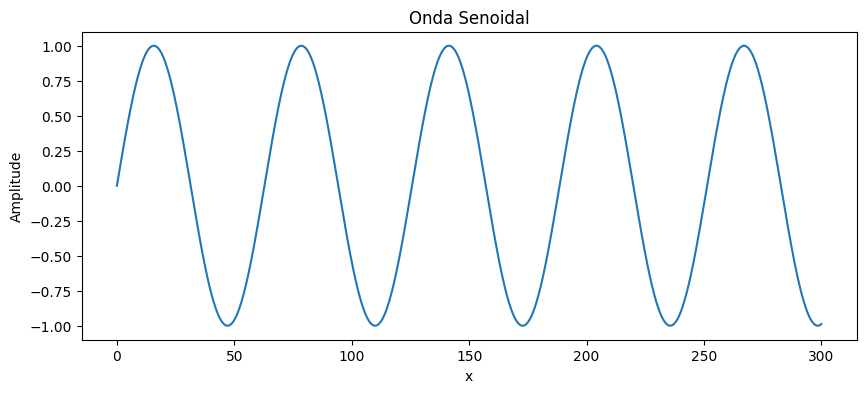

Shape X_treino: torch.Size([760, 50, 1])
Shape y_treino: torch.Size([760, 1])


In [3]:
# 1. Gerar a série temporal (onda senoidal)
amplitude = 1
frequency = 0.1
x = np.linspace(0, 300, 1000)
serie_temporal_np = amplitude * np.sin(frequency * x)

plt.figure(figsize=(10, 4))
plt.plot(x, serie_temporal_np)
plt.xlabel('x')
plt.ylabel('Amplitude')
plt.title('Onda Senoidal')
plt.show()

# A nossa senoide já está nesse intervalo, mas vamos deixar de referencia
scaler = MinMaxScaler(feature_range=(0, 1))
serie_normalizada = scaler.fit_transform(serie_temporal_np.reshape(-1, 1))

# 3. Criar sequências de input/output
def criar_sequencias(dados, tamanho_janela):
    X, y = [], []
    for i in range(len(dados) - tamanho_janela):
        X.append(dados[i:(i + tamanho_janela)])
        y.append(dados[i + tamanho_janela])
    return np.array(X), np.array(y)

tamanho_janela = 50 # Usar 50 passos anteriores para prever o próximo
X, y = criar_sequencias(serie_normalizada, tamanho_janela)

# 4. Dividir em treino e teste (80% treino, 20% teste)
tamanho_treino = int(len(X) * 0.8)
X_treino, X_teste = X[:tamanho_treino], X[tamanho_treino:]
y_treino, y_teste = y[:tamanho_treino], y[tamanho_treino:]

# 5. Converter para tensores do PyTorch e mover para o dispositivo
X_treino = torch.from_numpy(X_treino).float()
y_treino = torch.from_numpy(y_treino).float()
X_teste = torch.from_numpy(X_teste).float()
y_teste = torch.from_numpy(y_teste).float()

print(f"Shape X_treino: {X_treino.shape}") # (amostras, tamanho_janela, features)
print(f"Shape y_treino: {y_treino.shape}")

Agora vamos definir os modelos usando as implementações do Pytorch:

In [ ]:
class ModeloRecorrente(nn.Module):
    def __init__(self, tipo_modelo, input_size, hidden_size, num_layers, output_size, dropout=0.0):
        super(ModeloRecorrente, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        if tipo_modelo == 'RNN':
            self.recorrente = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        elif tipo_modelo == 'LSTM':
            self.recorrente = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        elif tipo_modelo == 'GRU':
            self.recorrente = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # A saída da camada recorrente contém (output, hidden_state)
        # Queremos apenas a saída do último passo de tempo
        out_recorrente, _ = self.recorrente(x)
        out = self.fc(out_recorrente[:, -1, :]) # Usar apenas a última saída da sequência
        return out

A função de treinamento:

In [113]:
def plot_loss(train_losses):
    plt.figure(figsize=(6, 2))
    plt.plot(train_losses, label='Loss de Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.title('Loss de Treinamento ao Longo das Épocas')
    plt.legend()
    plt.show()
    
def treinar_modelo(modelo, train_loader, num_epochs, learning_rate=1e-3,print_loss=True):
    criterion = nn.MSELoss(reduction='mean') # Erro Quadrático Médio, bom para regressão
    optimizer = torch.optim.Adam(modelo.parameters(), lr=learning_rate)
    train_avg_loss = []

    for epoch in range(num_epochs):
        modelo.train()
        total_loss = 0
        for X_treino, y_treino in train_loader:
            X_treino = X_treino.to(device)
            y_treino = y_treino.to(device)
        
            # Forward pass
            outputs = modelo(X_treino)
            loss = criterion(outputs, y_treino)
            total_loss += loss.item()

            # Backward e otimização
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        
        avg_loss = total_loss / len(train_loader)
        train_avg_loss.append(avg_loss)

        if ((epoch+1) % 10 == 0) and print_loss:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.5f}')

    plot_loss(train_avg_loss)

    return modelo

E a função para inferência:

In [89]:
def prever_e_plotar(modelo, X_teste, y_teste, scaler, passos_futuros=200, plot=True):
    modelo.eval()
    previsoes = []
    input_atual = X_teste[0].unsqueeze(0).clone().detach()
    out = y_teste.shape[1] 

    with torch.no_grad():
        for _ in range(passos_futuros):
            previsao = modelo(input_atual.to(device))
            previsoes.append(previsao.item())
            
            # Atualiza a janela de input: remove o valor mais antigo e adiciona a nova previsão
            nova_sequencia = torch.cat((input_atual[:, 1:, :], previsao.view(1, 1, out).to(input_atual.device)), dim=1)
            input_atual = nova_sequencia[0].unsqueeze(0)

    previsoes_desnormalizadas = scaler.inverse_transform(np.array(previsoes).reshape(-1, 1))
    dados_reais = scaler.inverse_transform(y_teste.cpu().numpy())

    # Plotar
    if plot:
        plt.figure(figsize=(6, 2))
        plt.plot(np.arange(len(dados_reais)), dados_reais, label='Dados Reais (Teste)')
        plt.plot(np.arange(len(previsoes_desnormalizadas)), previsoes_desnormalizadas, label='Previsão do Modelo')
        plt.title(f'Previsão vs Real - {modelo.recorrente.__class__.__name__}')
        plt.xlabel('Passos de Tempo')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()
    
    return previsoes_desnormalizadas

In [ ]:
# Parâmetros dos modelos 
INPUT_SIZE = 1
HIDDEN_SIZE = 64
NUM_LAYERS = 1
OUTPUT_SIZE = 1
EPOCHS = 100
BATCH_SIZE = 32

train_dataset = TensorDataset(X_treino, y_treino)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# --- Modelo 1: RNN Clássica ---
print("\n--- Treinando RNN Clássica ---")
rnn_model = ModeloRecorrente('RNN', INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(device)
rnn_model = treinar_modelo(rnn_model, train_loader, num_epochs=EPOCHS)
previsoes_rnn = prever_e_plotar(rnn_model, X_teste, y_teste, scaler)

# # --- Modelo 2: LSTM ---
print("\n--- Treinando LSTM ---")
lstm_model = ModeloRecorrente('LSTM', INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(device)
lstm_model = treinar_modelo(lstm_model, train_loader, num_epochs=EPOCHS)
previsoes_lstm = prever_e_plotar(lstm_model, X_teste, y_teste, scaler)

# --- Modelo 3: GRU ---
print("\n--- Treinando GRU ---")
gru_model = ModeloRecorrente('GRU', INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(device)
gru_model = treinar_modelo(gru_model, train_loader, num_epochs=EPOCHS)
previsoes_gru = prever_e_plotar(gru_model, X_teste, y_teste, scaler)

Comparando as 3:

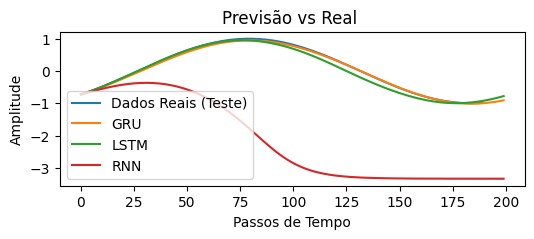

In [8]:
dados_verdadeiros =  scaler.inverse_transform(y_teste.cpu().numpy())

plt.figure(figsize=(6, 2))
plt.plot(np.arange(len(dados_verdadeiros)), dados_verdadeiros, label='Dados Reais (Teste)')
plt.plot(np.arange(len(previsoes_gru)), previsoes_gru, label='GRU')
plt.plot(np.arange(len(previsoes_lstm)), previsoes_lstm, label='LSTM')
plt.plot(np.arange(len(previsoes_rnn)), previsoes_rnn, label='RNN')
plt.title(f'Previsão vs Real ')
plt.xlabel('Passos de Tempo')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

**Reflita por um momento sobre os resultados obtidos nesse exemplo extremamente simples.**

Agora, vamos fazer as mesmas comparações para um dataset mais complexo. Temos duas opções:


**1.  Série de preço/volume das ações da NVIDIA**

A API do yahoo finance retorna as colunas:
- **Open**: O preço da ação no início do dia de negociação (primeiro preço registrado no dia).
- **Close**: O preço da ação no final do dia de negociação (último preço registrado).
- **High**: O preço mais alto atingido pela ação durante o dia de negociação.
- **Low**: O preço mais baixo da ação durante o dia de negociação.
- **Volume**: O número de ações negociadas durante o dia, representado em valores inteiros.

               Close      High       Low      Open      Volume
Date                                                          
1999-01-22  0.037607  0.044770  0.035577  0.040114  2714688000
1999-01-25  0.041547  0.042024  0.037607  0.040591   510480000
1999-01-26  0.038323  0.042860  0.037726  0.042024   343200000
1999-01-27  0.038204  0.039398  0.036293  0.038442   244368000
1999-01-28  0.038084  0.038442  0.037845  0.038204   227520000


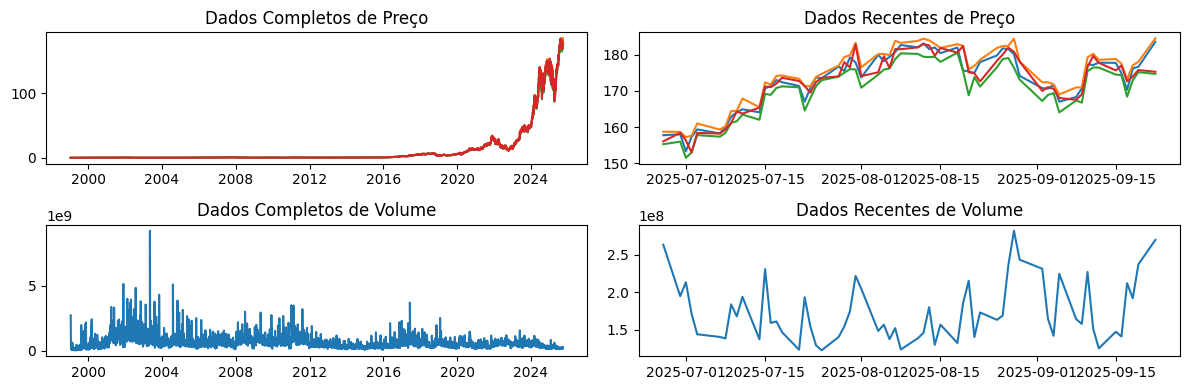

In [11]:
#script para baixar os dados da NVDA
# !pip install yfinance
# import yfinance as yf
# from datetime import date
# end_date = date.today().strftime("%Y-%m-%d")
# start_date = '1990-01-01'
# df = yf.download('NVDA', start=start_date, end=end_date).droplevel(1, axis=1) 

nvda = pd.read_csv('data/nvda.csv', parse_dates=['Date'], index_col='Date')
print(nvda.head())

fig, axs = plt.subplots(2, 2, figsize=(12, 4))

axs[0,0].plot(nvda.drop("Volume", axis=1)[:]) # Últimos 60 dias
axs[0,0].set_title('Dados Completos de Preço')

axs[0,1].plot(nvda.drop("Volume", axis=1)[-60:]) # Últimos 60 dias
axs[0,1].set_title('Dados Recentes de Preço')

axs[1,0].plot(nvda["Volume"][:]) # Últimos 60 dias
axs[1,0].set_title('Dados Completos de Volume')

axs[1,1].plot(nvda["Volume"][-60:]) # Últimos 60 dias
axs[1,1].set_title('Dados Recentes de Volume')

plt.tight_layout()
plt.show()

**2. Dados de clima diários de Delhi, India**

O [dataset do kaggle](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data/data) possui:

1. meantemp: Mean temperature averaged out from multiple 3 hour intervals in a day.
2. humidity: Humidity value for the day (units are grams of water vapor per cubic meter volume of air).
3. wind_speed: Wind speed measured in kmph.
4. meanpressure: Pressure reading of weather (measure in atm)

             meantemp   humidity  wind_speed  meanpressure
date                                                      
2013-01-01  10.000000  84.500000    0.000000   1015.666667
2013-01-02   7.400000  92.000000    2.980000   1017.800000
2013-01-03   7.166667  87.000000    4.633333   1018.666667
2013-01-04   8.666667  71.333333    1.233333   1017.166667
2013-01-05   6.000000  86.833333    3.700000   1016.500000


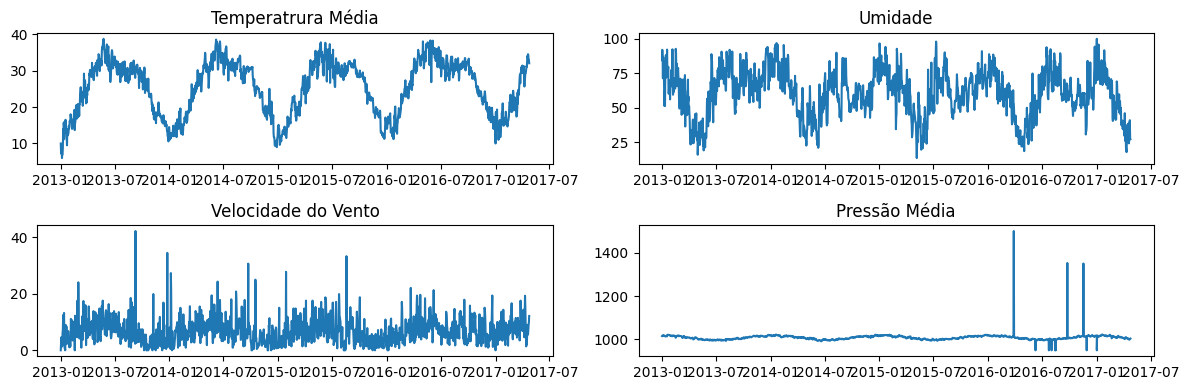

In [12]:
clima = pd.read_csv('data/Clima_Delhi.csv', parse_dates=['date'], index_col='date')
print(clima.head())

fig, axs = plt.subplots(2, 2, figsize=(12, 4))

axs[0,0].plot(clima['meantemp']) # Últimos 60 dias
axs[0,0].set_title('Temperatrura Média')

axs[0,1].plot(clima["humidity"]) # Últimos 60 dias
axs[0,1].set_title('Umidade')

axs[1,0].plot(clima["wind_speed"]) # Últimos 60 dias
axs[1,0].set_title('Velocidade do Vento')

axs[1,1].plot(clima["meanpressure"].clip(950,1500)) # Últimos 60 dias
axs[1,1].set_title('Pressão Média')

plt.tight_layout()
plt.show()

## Exercícios


1. Varie os parâmetros da rede criada (hidden state, número layers, dropout) para prever a série de preços/clima.
    - Você pode comparar as variações por arquitetura e depois o melhor de cada uma ou comparar as redes com os mesmos parâmetros, por exemplo. 
2. Escolha uma das variações acima e mude o input: preveja preço e volume / temperatura e umidade ao mesmo tempo;
3. Reflita sobre os todos resultados obtidos. Escolha pelo menos gráfico de cada item e poste no [github](https://github.com/liviameinhardt/deep-learning-course-fgv/issues/5). Faça um breve comentário com suas observações. 
- [Opcional] Implemente a variação CNN+LSTM. (São poucas linhas de código a mais)
- [Opcional] Você pode comparar seu resultados com modelos de séries temporais clássicos como ARIMA, ARMA, MA. .

Dicas/Notas:
- As redes treinam muito rápido e poucas alterações precisam ser feitas no código;
- Você não precisa exagerar nos testes (só se quiser), mas aumente um pouco o tamanho da rede para esses datasets para ver a diferença;
Exemplos: (HD: [64, 128]; NL: [1,3]; Dropout:[0, 0.2] já são 8 modelos por arquitetura.);
- Treine por mais de 100 epochs (sugestão: ~400);
- Caso demore mais de 7 minutos em um dos passos, veja a resposta abaixo para continuar. 

### resposta

In [ ]:
# item 1
class CNN_LSTM(nn.Module):
    def __init__(self, input_size, cnn_channels, kernel_size, lstm_hidden_size, lstm_layers, output_size):
        super(CNN_LSTM, self).__init__()
        self.cnn = nn.Conv1d(in_channels=input_size, out_channels=cnn_channels, kernel_size=kernel_size)
        self.lstm = nn.LSTM(input_size=cnn_channels, hidden_size=lstm_hidden_size,
                            num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, output_size)

    def forward(self, x):
        # x: [batch_size, seq_len, input_size]
        # Conv1d espera [batch_size, canais, seq_len], então fazemos permute
        x = x.permute(0, 2, 1)  # [batch_size, input_size, seq_len]
        x = self.cnn(x)          # [batch_size, cnn_channels, seq_len_out]
        x = x.permute(0, 2, 1)  # [batch_size, seq_len_out, cnn_channels]

        out, _ = self.lstm(x)   # [batch_size, seq_len_out, lstm_hidden_size]
        out = self.fc(out[:, -1, :])  # pegamos apenas o último passo de tempo
        return out

In [ ]:
#o item 2 é só fazer um for loop nos parametros e salvar os resultados para comparar...

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
serie_normalizada = scaler.fit_transform(clima[['meantemp', 'humidity']].values) #unica foi alteração aqui

# 3. Criar sequências de input/output
def criar_sequencias(dados, tamanho_janela):
    X, y = [], []
    for i in range(len(dados) - tamanho_janela):
        X.append(dados[i:(i + tamanho_janela)])
        y.append(dados[i + tamanho_janela])
    return np.array(X), np.array(y)

tamanho_janela = 12 # 
X, y = criar_sequencias(serie_normalizada, tamanho_janela)

# 4. Dividir em treino e teste (80% treino, 20% teste)
tamanho_treino = int(len(X) * 0.8)
X_treino, X_teste = X[:tamanho_treino], X[tamanho_treino:]
y_treino, y_teste = y[:tamanho_treino], y[tamanho_treino:]

# 5. Converter para tensores do PyTorch e mover para o dispositivo
X_treino = torch.from_numpy(X_treino).float()
y_treino = torch.from_numpy(y_treino).float()
X_teste = torch.from_numpy(X_teste).float()
y_teste = torch.from_numpy(y_teste).float()

print(f"Shape X_treino: {X_treino.shape}") # (amostras, tamanho_janela, features)
print(f"Shape y_treino: {y_treino.shape}")

Shape X_treino: torch.Size([1251, 12, 2])
Shape y_treino: torch.Size([1251, 2])



--- Treinando GRU ---


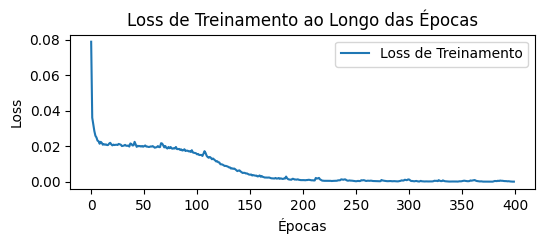


--- Treinando CNN + LSTM ---


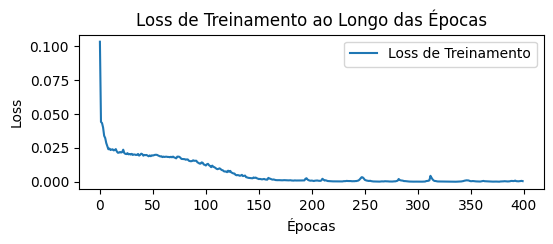

In [165]:
# Parâmetros dos modelos
INPUT_SIZE = 2
HIDDEN_SIZE = 64
NUM_LAYERS = 3
OUTPUT_SIZE = 2
EPOCHS = 400
BATCH_SIZE = 32
DROPOUT = 0.2

train_dataset = TensorDataset(X_treino, y_treino)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# # --- Modelo 1: RNN Clássica ---
# print("\n--- Treinando RNN Clássica ---")
# rnn_model = ModeloRecorrente('RNN', INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(device)
# rnn_model = treinar_modelo(rnn_model, train_loader, num_epochs=EPOCHS,print_loss=False)

# # # --- Modelo 2: LSTM ---
# print("\n--- Treinando LSTM ---")
# lstm_model = ModeloRecorrente('LSTM', INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT).to(device)
# lstm_model = treinar_modelo(lstm_model, train_loader, num_epochs=EPOCHS,print_loss=False)

# --- Modelo 3: GRU ---
print("\n--- Treinando GRU ---")
gru_model = ModeloRecorrente('GRU', INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(device)
gru_model = treinar_modelo(gru_model, train_loader, num_epochs=EPOCHS,print_loss=False)

# --- Modelo 4: CNN + LSTM ---
print("\n--- Treinando CNN + LSTM ---")
cnn_model = CNN_LSTM(INPUT_SIZE, 32, 3, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(device)
cnn_model = treinar_modelo(cnn_model, train_loader, num_epochs=EPOCHS,print_loss=False)

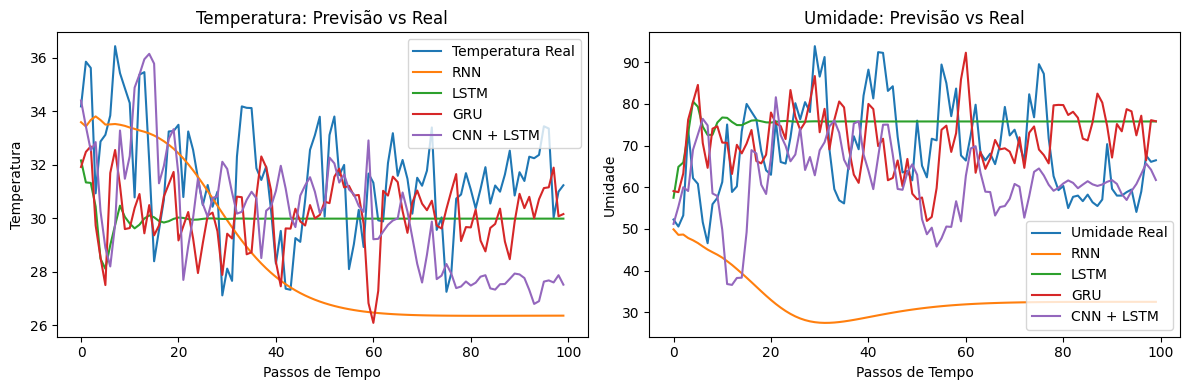

In [ ]:
def prever_duas_series(modelo, X_teste, y_teste, scaler,passos_futuros):

    modelo.eval()
    previsoes = []
    input_atual = X_teste[0].unsqueeze(0).clone().detach()
    out = y_teste.shape[1] #alteracao 1

    with torch.no_grad():
        for _ in range(passos_futuros):
            previsao = modelo(input_atual.to(device))
            previsoes.append(list(previsao[0].cpu().numpy())) #alteracao 2
            
            # Atualiza a janela de input: remove o valor mais antigo e adiciona a nova previsão
            nova_sequencia = torch.cat((input_atual[:, 1:, :], previsao.view(1, 1, out).to(input_atual.device)), dim=1)
            input_atual = nova_sequencia[0].unsqueeze(0)

    previsoes_desnormalizadas = scaler.inverse_transform(np.array(previsoes).reshape(-1, 2)) #alteracao 3
    dados_reais = scaler.inverse_transform(y_teste.cpu().numpy())

    return previsoes_desnormalizadas, dados_reais

passos_futuros = 100
rnn_previsoes, dados_reais = prever_duas_series(rnn_model, X_teste, y_teste, scaler, passos_futuros=passos_futuros)
lstm_previsoes, _ = prever_duas_series(lstm_model, X_teste, y_teste, scaler, passos_futuros=passos_futuros)
gru_previsoes, _ = prever_duas_series(gru_model, X_teste, y_teste, scaler, passos_futuros=passos_futuros)
cnn_previsoes, _ = prever_duas_series(cnn_model, X_teste, y_teste, scaler, passos_futuros=passos_futuros)

# Plotar
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(passos_futuros), dados_reais[:passos_futuros, 0], label='Temperatura Real')
plt.plot(np.arange(len(rnn_previsoes)), rnn_previsoes[:, 0], label='RNN')
plt.plot(np.arange(len(lstm_previsoes)), lstm_previsoes[:, 0], label='LSTM')
plt.plot(np.arange(len(gru_previsoes)), gru_previsoes[:, 0], label='GRU')
plt.plot(np.arange(len(cnn_previsoes)), cnn_previsoes[:, 0], label='CNN + LSTM')
plt.title(f'Temperatura: Previsão vs Real')
plt.xlabel('Passos de Tempo')
plt.ylabel('Temperatura')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(passos_futuros), dados_reais[:passos_futuros, 1], label='Umidade Real')
plt.plot(np.arange(len(rnn_previsoes)), rnn_previsoes[:, 1], label='RNN')
plt.plot(np.arange(len(lstm_previsoes)), lstm_previsoes[:, 1], label='LSTM')
plt.plot(np.arange(len(gru_previsoes)), gru_previsoes[:, 1], label='GRU')
plt.plot(np.arange(len(cnn_previsoes)), cnn_previsoes[:, 1], label='CNN + LSTM')
plt.title(f'Umidade: Previsão vs Real')
plt.xlabel('Passos de Tempo')
plt.ylabel('Umidade')
plt.legend()

plt.tight_layout()
plt.show()
